In [27]:
# import modules
import pandas as pd
import numpy as np
import string
import re
import spacy
import nltk
from string import punctuation
import csv

import matplotlib.pyplot as plt

from collections import Counter
from typing import List

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import text 
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.metrics.pairwise import cosine_similarity

import networkx as nx
# import json
# from dateutil import parser

In [29]:

# set the file path for scraped jobs 
file_path = 'swe_us_ft_4wks_041923.csv'

# read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

df

,title,company,location,salary,link,descriptions
0,Software Engineer,Mavis Discount Tire,"Millwood, NY 10546","$100,000 - $130,000 a year",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Mavis Discount Tire - Software Engineer\nMavis...
1,Software Engineer (TS/SCI W/ CI Poly),Recro LLC,"Dulles, VA","$150,000 - $200,000 a year",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Recro is looking for a motivated, career and c..."
2,Sr. Software Engineer | MES Solutions,RedViking,"Hybrid remote in Plymouth, MI 48170",Estimated $119K - $150K a year,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Description:Are you ready to leverage new tech...
3,Senior Software Engineer (C++/Python) for Scie...,Block Engineering,"Hybrid remote in Southborough, MA 01772","$150,000 - $200,000 a year",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Block Engineering is a leading developer of la...
4,SEO/PPC Specialist,The AD Leaf Marketing Firm LLC.,"Melbourne, FL 32935",$16 - $19 an hour,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"We are a growing team of top-notch, innovative..."
...,...,...,...,...,...,...
93,Adept Software Engineer,CBT Nuggets,"Remote in Eugene, OR 97401","$100,000 - $150,000 a year",https://www.indeed.com/rc/clk?jk=45d2e48f422a8...,Why CBT Nuggets is a great place to work:\n\nW...
94,Software Engineer,Resourcely,Remote,Estimated $108K - $137K a year,https://www.indeed.com/rc/clk?jk=f9adce41f34a3...,Job Description\nWe're building software that ...
95,"Staff Software Engineer, Frontend",Recruit4Work S.L.,Remote,Estimated $150K - $190K a year,https://www.indeed.com/rc/clk?jk=8fc589205220e...,My client is seeking to appoint a sensational ...
96,Backend Engineer,"Polygon.io, Inc",Remote,Estimated $119K - $151K a year,https://www.indeed.com/rc/clk?jk=6aaec5092396c...,About this role\nWe are seeking a high perform...


In [30]:

# find type of work (remote, hybrid, or inperson) and state if applicable
work_week = []

for loc in df['location']:
    state_match = re.findall(r'(?<![A-Z])[A-Z]{2}(?![A-Z])', loc)
    
    if 'hybrid' in loc.lower():
        job_type = 'hybrid'
    elif 'remote' in loc.lower():
        job_type = 'remote'
        state_match = ['remote']
    else:
        job_type = 'in-person'
        
    work_week.append((job_type,state_match[0]))
    
df['type'], df['location'] = zip(*work_week)

# reformat salary column to avg annual
hrs_per_year = 40*52
salary = []

for s in df['salary']:
    if type(s) == str and any(ch.isdigit() for ch in s):
        # Define the regular expression pattern to match salary ranges
        pattern = r'\$([\d,]+)'
        # Use regular expression to extract the lower and upper bound of the salary range
        match = re.findall(pattern, s.replace(',',''))
        avg_salary = sum([int(m) for m in match])/len(match)
        # adjust to annual
        if 'an hour' in s:
            avg_salary = avg_salary*hrs_per_year
        if 'month' in s:
            avg_salary = avg_salary*12
        if 'Estimated' in s:
            avg_salary = avg_salary*1000
        
        s = avg_salary
        
    salary.append(s)

df['salary'] = salary

df


,title,company,location,salary,link,descriptions,type
0,Software Engineer,Mavis Discount Tire,NY,115000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Mavis Discount Tire - Software Engineer\nMavis...,in-person
1,Software Engineer (TS/SCI W/ CI Poly),Recro LLC,VA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Recro is looking for a motivated, career and c...",in-person
2,Sr. Software Engineer | MES Solutions,RedViking,MI,134500.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Description:Are you ready to leverage new tech...,hybrid
3,Senior Software Engineer (C++/Python) for Scie...,Block Engineering,MA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Block Engineering is a leading developer of la...,hybrid
4,SEO/PPC Specialist,The AD Leaf Marketing Firm LLC.,FL,36400.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"We are a growing team of top-notch, innovative...",in-person
...,...,...,...,...,...,...,...
93,Adept Software Engineer,CBT Nuggets,remote,125000.0,https://www.indeed.com/rc/clk?jk=45d2e48f422a8...,Why CBT Nuggets is a great place to work:\n\nW...,remote
94,Software Engineer,Resourcely,remote,122500.0,https://www.indeed.com/rc/clk?jk=f9adce41f34a3...,Job Description\nWe're building software that ...,remote
95,"Staff Software Engineer, Frontend",Recruit4Work S.L.,remote,170000.0,https://www.indeed.com/rc/clk?jk=8fc589205220e...,My client is seeking to appoint a sensational ...,remote
96,Backend Engineer,"Polygon.io, Inc",remote,135000.0,https://www.indeed.com/rc/clk?jk=6aaec5092396c...,About this role\nWe are seeking a high perform...,remote


In [32]:
def tokenize_a_doc(doc, nlp, lemmatized=True, remove_stopword=True, remove_punct=True): 
    clean_tokens = []
    # load current doc into spacy nlp model and split sentences by newline chars
    sentences = doc.split("\n")
    for sentence in sentences:
        doc = nlp(sentence)
        # clean either lemmatized unigrams or unmodified doc tokens
        if lemmatized:
            clean_tokens += [token.lemma_.lower() for token in doc            # using spacy nlp params, skip token if:
                            if (not remove_stopword or not token.is_stop)     # it is a stopword and remove_stopwords = True
                            and (not remove_punct or not token.is_punct)      # it is punctuation and remove_punct = True
                            and not token.lemma_.isspace()]                   # it is whitespace                               
        else:
            clean_tokens += [token.text.lower() for token in doc 
                            if (not remove_stopword or not token.is_stop) 
                            and (not remove_punct or not token.is_punct) 
                            and not token.text.isspace()]
    return clean_tokens

def tokenize(docs, lemmatized=True, remove_stopword=True, remove_punct=True):
    # load in spacy NLP model and disable unused pipelines to reduce processing time/memory space
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    nlp.add_pipe("sentencizer")
    # tokenize each doc in the corpus using specified params for lemmatization and removal conditions
    tokens = [tokenize_a_doc(doc, nlp, lemmatized, remove_stopword, remove_punct) for doc in docs]
     # drop terms that appear in at least 80 docs, or 5 docs or less, and additional stop words
    add_stop = ['e.g.']
    tokens = drop_top_and_bottom(tokens, 80, 5, add_stop)  
    return tokens


def drop_top_and_bottom(tokens, top, bot, add_stop):
    docs_tokens = {idx:nltk.FreqDist(tokens) for idx,tokens in enumerate(tokens)}
    dtm=pd.DataFrame.from_dict(docs_tokens, orient="index").fillna(0).sort_index(axis = 0)
    docs_per_term = dtm.astype(bool).sum(axis=0)

    tokens = [[token for token in t if (docs_per_term[token] > bot and docs_per_term[token] < top 
                                        and token not in add_stop)] for t in tokens]
    
    return tokens

tokens = tokenize(df['descriptions'], lemmatized=True, remove_stopword=True, remove_punct=True)
df['cleaned_desc'] = pd.Series(tokens).apply(lambda x: " ".join(x))


df


,title,company,location,salary,link,descriptions,type,cleaned_desc
0,Software Engineer,Mavis Discount Tire,NY,115000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Mavis Discount Tire - Software Engineer\nMavis...,in-person,engineer large independently hold sale united ...
1,Software Engineer (TS/SCI W/ CI Poly),Recro LLC,VA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Recro is looking for a motivated, career and c...",in-person,look motivated career customer orient engineer...
2,Sr. Software Engineer | MES Solutions,RedViking,MI,134500.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Description:Are you ready to leverage new tech...,hybrid,description leverage new technology expand lea...
3,Senior Software Engineer (C++/Python) for Scie...,Block Engineering,MA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Block Engineering is a leading developer of la...,hybrid,engineering lead developer base system proud i...
4,SEO/PPC Specialist,The AD Leaf Marketing Firm LLC.,FL,36400.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"We are a growing team of top-notch, innovative...",in-person,grow innovative highly detail orient professio...
...,...,...,...,...,...,...,...,...
93,Adept Software Engineer,CBT Nuggets,remote,125000.0,https://www.indeed.com/rc/clk?jk=45d2e48f422a8...,Why CBT Nuggets is a great place to work:\n\nW...,remote,great place office remotely united states life...
94,Software Engineer,Resourcely,remote,122500.0,https://www.indeed.com/rc/clk?jk=f9adce41f34a3...,Job Description\nWe're building software that ...,remote,job description build empower user create secu...
95,"Staff Software Engineer, Frontend",Recruit4Work S.L.,remote,170000.0,https://www.indeed.com/rc/clk?jk=8fc589205220e...,My client is seeking to appoint a sensational ...,remote,client seek staff engineer frontend help shape...
96,Backend Engineer,"Polygon.io, Inc",remote,135000.0,https://www.indeed.com/rc/clk?jk=6aaec5092396c...,About this role\nWe are seeking a high perform...,remote,role seek high perform backend engineer help b...


In [35]:
df['cleaned_desc'].loc[0]

'engineer large independently hold sale united states change engineers lead combine company location state service offer value customer complete service include change understand people great people build customer relationship allow leader industry continue provide good customer build new technology store industry seek react engineer familiarity web platform join end engineers engage product write great build engage product technical relational skill build business critical application high perform cross functional operate small closely person wide variety project range new website enhance store technology product production today build range platform web stack today include react node.js typescript .net production qualification strong javascript typescript node.js skill necessary position 5 + variety additional backend technology preferably react java .net able come office 5 day week strong ui ux api design difference enhancement solution aws azure familiarity cloud service aws azure 

In [18]:

# find k most popular n-grams
def most_popular_ngrams(corpus, n, top_k):
    # Create a TfidfVectorizer with n-grams
    params = {
        'ngram_range':n,
        'smooth_idf':True
    }
    vectorizer = TfidfVectorizer(**params)
    
    # get term-document matrix
    tfidf_matrix = vectorizer.fit_transform(corpus)
    smoothed_tfidf = tfidf_matrix.toarray()
    
    # Calculate the average score for each n-gram
    avg_score = np.mean(smoothed_tfidf, axis=0)
    
    # Get the top-k n-grams based on their average TF-IDF scores
    ngrams = vectorizer.get_feature_names_out()
    top_ngrams = sorted(zip(ngrams, avg_score), key=lambda x: x[1], reverse=True)[:top_k]
    top_ngrams_list = [ngram for ngram, score in top_ngrams]
    
    return top_ngrams_list, pd.DataFrame(smoothed_tfidf, columns = ngrams)

# get top phrases 
n = 3
top_k = 500

popular_phrases, smoothed_tfidf_ngrams = most_popular_ngrams(df['cleaned_desc'], (n,n), top_k)
print(f'Top {top_k} phrases using full cleaned description:\n \n{popular_phrases}\n')

n = 1
popular_phrases, smoothed_tfidf_ngrams = most_popular_ngrams(df['cleaned_desc'], (n,n), top_k)
print(f'Top {top_k} phrases using full cleaned description:\n \n{popular_phrases}\n')



Top 500 phrases using full cleaned description:
 
['degree computer science', 'job type time', 'equal opportunity employer', 'type time pay', 'insurance pay time', 'time pay benefit', 'schedule hour shift', 'bachelor degree computer', 'pay benefit 401', 'medical dental vision', 'remote health insurance', 'computer science related', 'vision insurance schedule', 'location remote health', 'shift monday friday', '401 matching dental', 'matching dental insurance', 'science related field', '401 401 matching', 'benefit 401 401', 'java developer training', 'stack java developer', 'problem solve skill', 'sexual orientation gender', 'race color religion', 'required location remote', 'dental insurance health', 'insurance health insurance', 'life insurance pay', 'orientation gender identity', 'equal employment opportunity', 'fast pace environment', 'computer science computer', 'science computer engineering', 'ability commute relocate', 'commute planning relocate', 'planning relocate start', 'relia

Top 20 phrases using full cleaned description:
 
['degree computer science', 'job type time', 'equal opportunity employer', 'type time pay', 'insurance pay time', 'time pay benefit', 'schedule hour shift', 'bachelor degree computer', 'pay benefit 401', 'medical dental vision', 'remote health insurance', 'computer science related', 'vision insurance schedule', 'location remote health', 'shift monday friday', '401 matching dental', 'matching dental insurance', 'science related field', '401 401 matching', 'benefit 401 401']



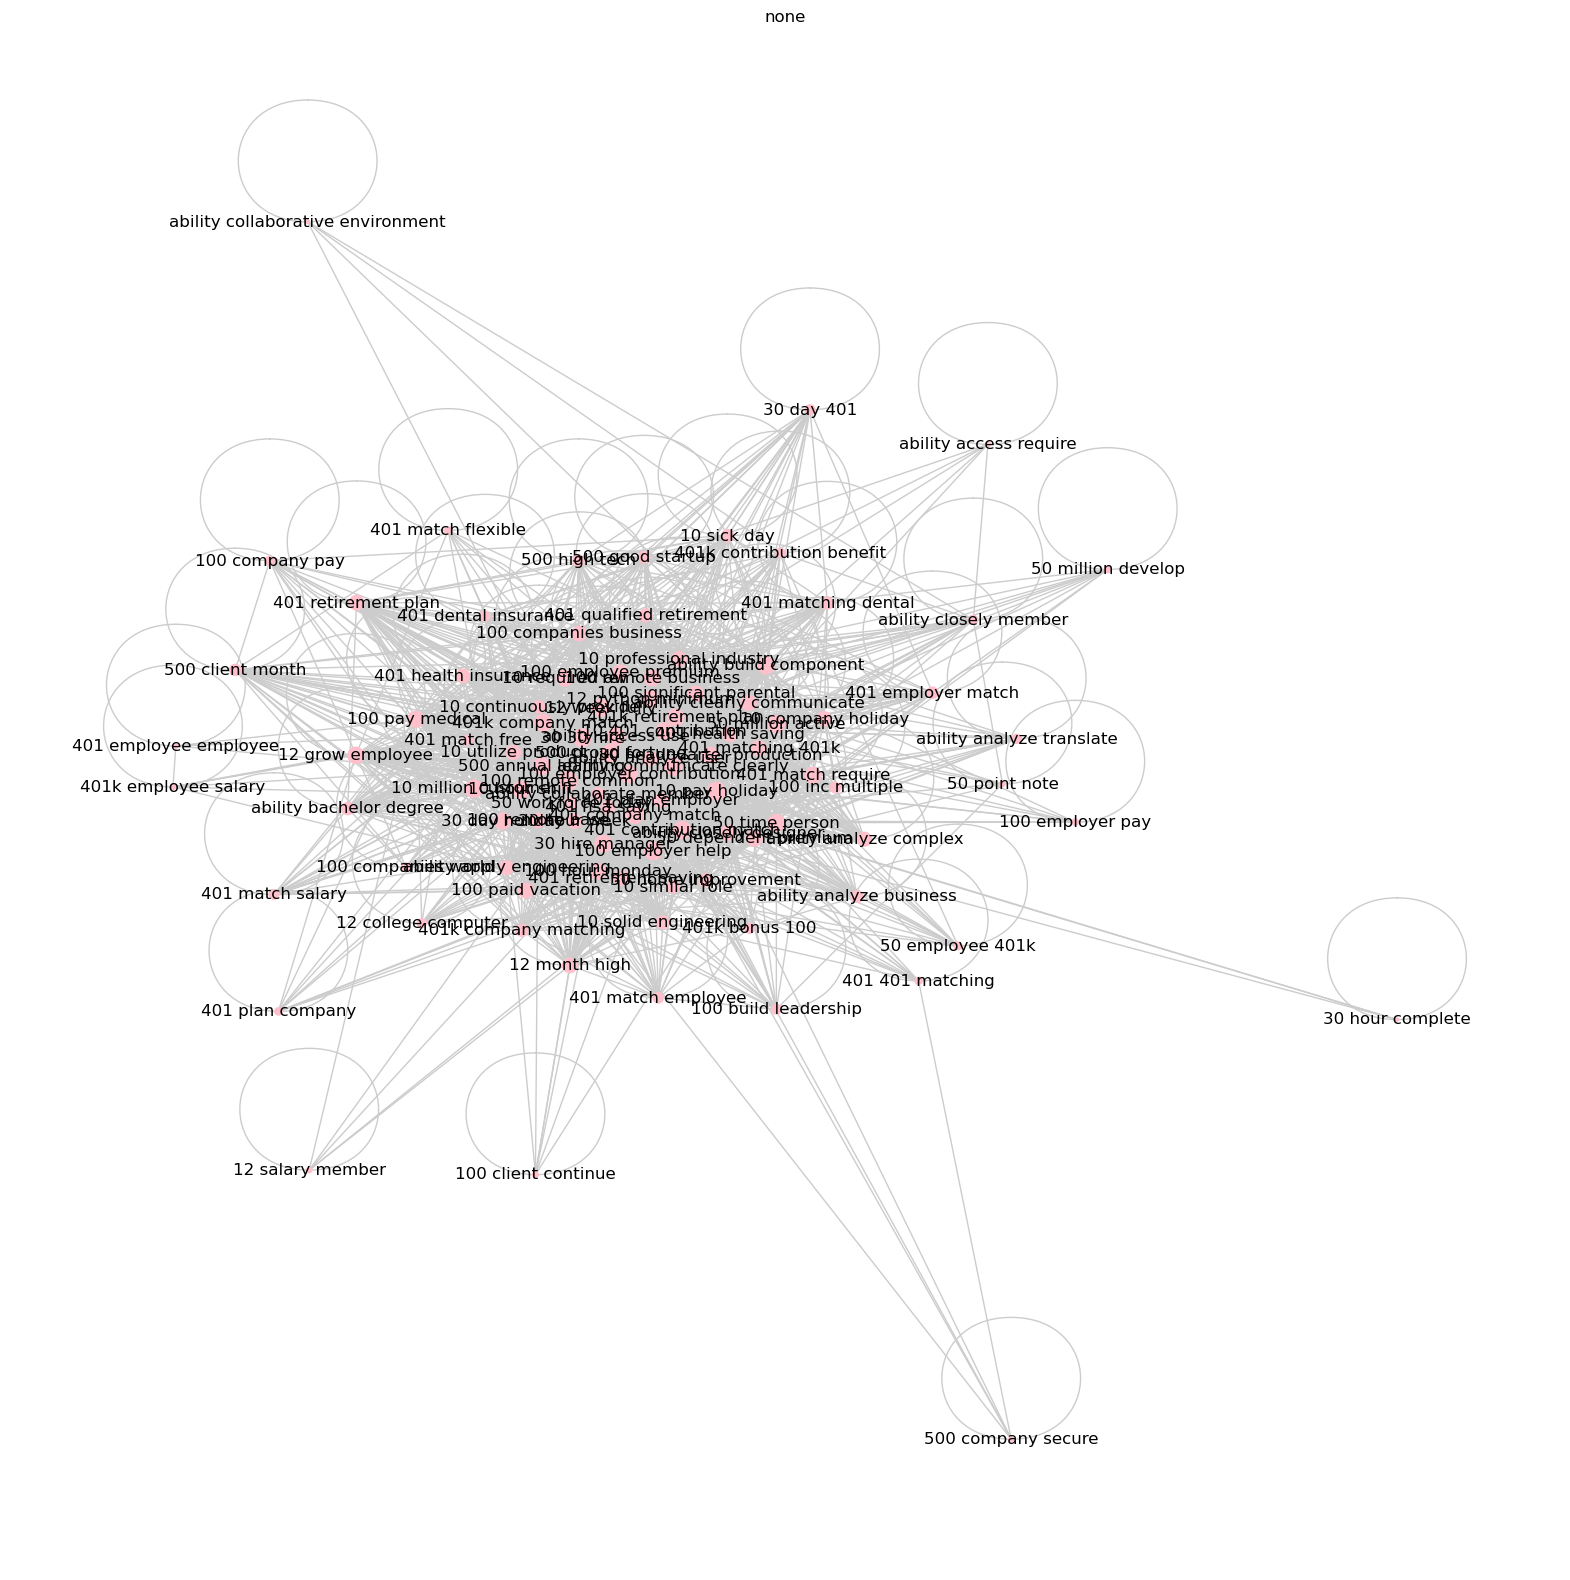

In [36]:
# show semantic network


n = 3
top_k = 20
popular_phrases, smoothed_tfidf_ngrams = most_popular_ngrams(df['cleaned_desc'], (n,n), top_k)
print(f'Top {top_k} phrases using full cleaned description:\n \n{popular_phrases}\n')

# Compute cosine similarity between smoothed TF-IDF vectors
similarity_matrix = cosine_similarity(smoothed_tfidf_ngrams)

# Create a semantic network as a graph
G = nx.Graph()
G = nx.from_numpy_matrix(similarity_matrix, create_using=nx.Graph()) # creating from adjacency matrix 
node_name = dict(zip(range(0,len(list(G.nodes()))), smoothed_tfidf_ngrams.columns))  
G = nx.relabel_nodes(G, node_name)

# Take a look
plt.figure(figsize=(20,20), dpi=100)

# node size proportional to eigenvector centrality of words
node_size= [x*1000 for x in nx.eigenvector_centrality(G).values()]

# choose a layout function
pos=nx.kamada_kawai_layout(G)

# edge color
edge_color='0.8'

nx.drawing.nx_pylab.draw_networkx(G,
                                  node_size=node_size, 
                                  node_color = "pink",
                                  pos=pos,
                                  edge_color=edge_color,
                                  with_labels=True,
                                 font_size=12)
plt.title('none')
plt.axis("off") 
plt.show()

In [11]:

def most_popular_skills(phrases, skills, n):
    vectorizer = CountVectorizer().fit_transform(phrases + skills)
    similarity_matrix = cosine_similarity(vectorizer)[:len(phrases), len(phrases):]
    
    average_similarities = np.mean(similarity_matrix, axis=0)
    sorted_indices = np.argsort(average_similarities)[::-1]
    
    popular_elements = [skills[i] for i in sorted_indices[:n]]
    return popular_elements


tech_skills = pd.read_csv('Hot_Technologies_Software_Developer_ONET.csv')
tech_skills = tech_skills.loc[tech_skills['In Demand'] == 'Yes']
tech_skill_names = tech_skills['Technology Skill'].apply(lambda x: x.lower().replace('software','')).to_list()

soft_skills = pd.read_csv('soft_skills.csv')
soft_skill_names = soft_skills['skill_name']

n = 20
most_popular = most_popular_skills(popular_phrases, tech_skill_names, n)
print(f'\nTop {n} popular technical skills based on top n-grams: \n{most_popular}')


most_popular = most_popular_skills(popular_phrases, list(soft_skill_names), n)
print(f'\nTop {n} popular soft skills based on top n-grams: \n{most_popular}')




Top 20 popular technical skills based on top n-grams: 
['oracle java', 'typescript', 'react', 'python', 'google angular', 'javascript', 'amazon web services aws ', 'javascript object notation json', 'spring framework', 'structured query language sql', 'hypertext markup language html', 'microsoft .net framework', 'node.js', 'microsoft sql server', 'jenkins ci', 'git', 'cascading style sheets css', 'extensible markup language xml', 'spring boot', 'postgresql']

Top 20 popular soft skills based on top n-grams: 
['ability to manage time', 'time management', 'ability to work within flexible time frames', 'communication skill', 'ability to provide training', 'ability to work in a flexible schedule', 'ability to meet a schedule', 'ability to keep within time limits', 'ability to work with time limitations', 'ability to work within time frames', 'ability to work within strict time', 'ability to work under time pressure', 'ability to work within time limits', 'ability to deliever tasks on time

In [12]:
states = 'AL, AK, AZ, AR, CA, CO, CT, DE, DC, FL, GA, HI, ID, IL, IN, IA, KS, KY, LA, ME, MD, \
MA, MI, MN, MS, MO, MT, NE, NV, NH, NJ, NM, NY, NC, ND, OH, OK, OR, PA, PR, RI, SC, \
SD, TN, TX, UT, VT, VA, WA, WV, WI, WY'.split(', ')

annual_mean_wage = pd.read_csv('mean_annual_salary_swe.csv').loc[:51]
annual_mean_wage['Area Name'] = pd.Series(states)

# get US mean salary then convert state salary stats to dict with {state:avg_salary}
us_avg_salary = round(annual_mean_wage['Annual mean wage'].mean(), 0)
annual_mean_wage = dict(zip(annual_mean_wage.iloc[:,0],annual_mean_wage.iloc[:,1]))

# calculate salary difference in comparison to location average
salary_delta = []
for i,location in enumerate(df['location']):
    salary = df['salary'][i]
    # if salary is known
    if type(salary) != 'str':
        # if remote, take difference from US average, else use state average
        if location != 'remote':
            salary_delta.append(salary-annual_mean_wage[location])
        else:
            salary_delta.append(salary-us_avg_salary)
    else:
        salary_delta.append(salary)

df['salary_delta'] = salary_delta
df


,title,company,location,salary,link,descriptions,type,cleaned_desc,salary_delta
0,Software Engineer,Mavis Discount Tire,NY,115000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Mavis Discount Tire - Software Engineer\nMavis...,in-person,engineer large independently hold sale united ...,-14950.0
1,Software Engineer (TS/SCI W/ CI Poly),Recro LLC,VA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Recro is looking for a motivated, career and c...",in-person,look motivated career customer orient engineer...,47170.0
2,Sr. Software Engineer | MES Solutions,RedViking,MI,134500.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Description:Are you ready to leverage new tech...,hybrid,description leverage new technology expand lea...,36770.0
3,Senior Software Engineer (C++/Python) for Scie...,Block Engineering,MA,175000.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Block Engineering is a leading developer of la...,hybrid,engineering lead developer base system proud i...,46810.0
4,SEO/PPC Specialist,The AD Leaf Marketing Firm LLC.,FL,36400.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"We are a growing team of top-notch, innovative...",in-person,grow innovative highly detail orient professio...,-68800.0
...,...,...,...,...,...,...,...,...,...
93,Adept Software Engineer,CBT Nuggets,remote,125000.0,https://www.indeed.com/rc/clk?jk=45d2e48f422a8...,Why CBT Nuggets is a great place to work:\n\nW...,remote,great place office remotely united states life...,17979.0
94,Software Engineer,Resourcely,remote,122500.0,https://www.indeed.com/rc/clk?jk=f9adce41f34a3...,Job Description\nWe're building software that ...,remote,job description build empower user create secu...,15479.0
95,"Staff Software Engineer, Frontend",Recruit4Work S.L.,remote,170000.0,https://www.indeed.com/rc/clk?jk=8fc589205220e...,My client is seeking to appoint a sensational ...,remote,client seek staff engineer frontend help shape...,62979.0
96,Backend Engineer,"Polygon.io, Inc",remote,135000.0,https://www.indeed.com/rc/clk?jk=6aaec5092396c...,About this role\nWe are seeking a high perform...,remote,role seek high perform backend engineer help b...,27979.0
